In [24]:
from os import listdir
from os.path import join
import os.path

from PIL import Image

import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torchvision
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchsummary import summary

from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt

import random

In [25]:
import gdown
import patoolib

url       = 'https://drive.google.com/uc?id='
file_id   = '1iVt97n4fpFKUeTW93kNGMzbadRbHCjUf'
data_path = '../data/'
data_dir  = 'extracted_images'
data_file = 'math_data.rar'

if os.path.isdir(data_path+data_dir):
    print('already exist')

elif not os.path.isfile(data_path+data_file):
    gdown.download(url + file_id, data_path+data_file, quiet=False)
    patoolib.extract_archive(data_path+data_file, outdir='../data/')
    
else:
    patoolib.extract_archive(data_path+data_file, outdir='../data/')


already exist


In [26]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'using {device}')

using cuda


In [27]:
print("")
label = {}
num = 0
for className in listdir(join(data_path, "extracted_images")) :
  print(f"{className}:{len(listdir(join(data_path, 'extracted_images', className)))}")
  label[className] = num
  num += 1


v:1558
,:1906
beta:2025
cos:2986
4:7396
forward_slash:199
prime:329
G:1692
mu:177
ascii_124:1339
{:376
Delta:137
7:2909
sin:4293
forall:45
):14355
lim:1675
lambda:109
9:3737
k:3074
pi:2332
}:377
z:5870
geq:693
A:12367
(:14294
i:5140
p:2680
f:3712
o:449
5:3545
tan:2450
T:3274
j:1536
l:1017
phi:355
C:5802
y:9340
neq:558
R:2671
]:780
M:2476
8:3068
e:3003
sum:2689
0:6914
q:1230
b:8651
!:1300
u:1269
=:13104
leq:973
div:868
-:33997
sqrt:8908
rightarrow:1703
2:26141
w:556
gamma:409
ldots:609
pm:802
X:26594
infty:1783
exists:21
lt:477
1:26520
d:4852
N:10862
gt:258
theta:2796
sigma:201
6:3118
+:25112
[:778
times:3251
log:2001
in:47
int:2742
alpha:2546
3:10909
H:1464
S:1413


In [28]:
# class MathDataSet(Dataset):
#   def __init__(self):
#     pass

#   def __len__(self):
#     pass
  
#   def __getitem__(self):
#     pass



class myDataLoader(Dataset) :
  def __init__(self, opt, forMetric) :
    super(myDataLoader, self).__init__()

    self.opt = opt
    self.forMetric = forMetric
    self.imageDataset = self.getPathList()
    self.label = label
    
  def __getitem__(self, index) :
    image = Image.open(self.imageDataset[0][index]).convert("RGB") #4D to 3D
    image = self.transforms(image)

    label = self.label[self.imageDataset[1][index]]
    
    return {"image":image, "label":torch.as_tensor(label).float()}
    
  def __len__(self) :
    return len(self.imageDataset[1])

  def getPathList(self) :
    if self.forMetric :
      classPath = join(self.opt["dataRoot"], "test")
    else :
      classPath = join(self.opt["dataRoot"], "train")

    imagePathList, imageLabelList = [], []
    for className in listdir(classPath) :
      for imageName in listdir(join(classPath, className)) :
        imagePathList.append(join(classPath, className, imageName))
        imageLabelList.append(className)
    
    return (imagePathList, imageLabelList)
  
  def transforms(self, image) :
    if self.forMetric :
      myTransforms = transforms.Compose([transforms.Resize(self.opt["cropSize"]),
                                        transforms.ToTensor()]) # Resize Process for Test
    else :
      myTransforms = transforms.Compose([transforms.RandomCrop(self.opt["cropSize"]),
                                        transforms.ToTensor()]) # Random Crop for Training
    image = myTransforms(image)

    return image

In [29]:
trans = transforms.Compose([transforms.Resize((100,100)),
                            transforms.ToTensor(),
                            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                            ])
trainset = torchvision.datasets.ImageFolder(root = data_path + 'extracted_images',
                                            transform = trans)

len(trainset.classes)

82

In [30]:
classes = trainset.classes

In [31]:
train_size = int(0.8 * len(trainset))
test_size = len(trainset) - train_size

train_data, test_data = torch.utils.data.random_split(trainset, [train_size, test_size])

train_loader = DataLoader(train_data,
                         batch_size = 16,
                         shuffle = True)

test_loader = DataLoader(test_data,
                         batch_size = 16,
                         shuffle = False)

print(f'train size = {train_size}\ntest size = {test_size}')
print('')
print(f'training data set = {len(train_loader)}\ntest data set = {len(test_loader)}')

train size = 300779
test size = 75195

training data set = 18799
test data set = 4700


In [32]:
dataiter = iter(train_loader)
images, labels = next(dataiter)
print(images.size())
print(labels.size())

torch.Size([16, 3, 100, 100])
torch.Size([16])


In [33]:
def imshow(img):
  img = img / 2 + 0.5
  np_img = img.numpy()
  plt.imshow(np.transpose(np_img, (1,2,0)))
  print(np_img.shape)
  print((np.transpose(np_img, (1,2,0))).shape)


torch.Size([16, 3, 100, 100])
(3, 410, 410)
(410, 410, 3)
torch.Size([16, 3, 100, 100])
torch.Size([3, 206, 818])
    )     +     1     2   sum     3  sqrt     3     N     2     -     b     -     5     N     y 


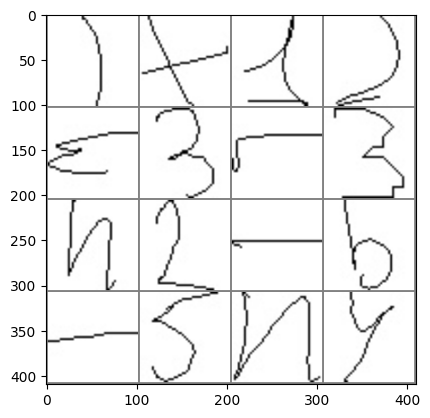

In [34]:
print(images.shape)
imshow(torchvision.utils.make_grid(images, nrow = 4))
print(images.shape)
print((torchvision.utils.make_grid(images)).shape)
print(''.join('%5s '%classes[labels[j]] for j in range(16)))

In [35]:
class myModel(nn.Module) :
  def __init__(self, opt) :
    super(myModel, self).__init__()

    inputDim, targetDim, channels = 3, len(label), 64

    self.layer0 = nn.Sequential(nn.Conv2d(inputDim, channels, kernel_size=3, stride=1, padding=1),
                                nn.ReLU(),
                                nn.MaxPool2d(kernel_size=2, stride=2))
    self.layer1 = nn.Sequential(nn.Conv2d(channels, channels*2, kernel_size=3, stride=1, padding=1),
                                nn.ReLU(),
                                nn.MaxPool2d(kernel_size=2, stride=2))
    self.layer2 = nn.Sequential(nn.Conv2d(channels*2, channels*4, kernel_size=3, stride=1, padding=1),
                                nn.ReLU(),
                                nn.MaxPool2d(kernel_size=2, stride=2))
    self.layer3 = nn.Sequential(nn.Conv2d(channels*4, channels*4, kernel_size=3, stride=1, padding=1),
                                nn.ReLU(),
                                nn.MaxPool2d(kernel_size=2, stride=2))
    self.layer4 = nn.Linear(channels*4, targetDim)

  def forward(self, input) :
    output = self.layer0(input)
    output = self.layer1(output)
    output = self.layer2(output)
    output = self.layer3(output)
    output = F.adaptive_avg_pool2d(output, (1,1)).view(output.size(0), -1)
    output = self.layer4(output)

    return output
     

In [36]:
def fixSeed(seed) :
  random.seed(seed)
  np.random.seed(seed)
  torch.manual_seed(seed)
  torch.cuda.manual_seed(seed)
  torch.cuda.manual_seed_all(seed)
  torch.backends.cudnn.deterministic = True
  torch.backends.cudnn.benchmark = False

In [37]:
class AverageMeter(object):
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val*n
        self.count += n
        self.avg = self.sum / self.count

In [38]:
def computeAcc(pred, target) :
  acc = (torch.argmax(pred)==torch.argmax(target)).sum()/pred.size(0)

  return acc

In [39]:
opt = {"dataRoot":"/content/",
       "cropSize":100,
       "seed":42,
       "inputDim":3,
       "targetDim":len(trainset.classes),
       "channels":64,
       "batchSize":16, 
       "lr":1e-4, 
       "epochs":10, 
       "isCUDA":torch.cuda.is_available()}

In [40]:
def train(opt, myDataLoader, myModel, criterion) :
  fixSeed(opt["seed"])

  trainDataLoader = train_loader
  testDataLoader = test_loader

  fixSeed(opt["seed"])
  model = myModel(opt)
  if opt["isCUDA"] :
    model = model.cuda()

  summary(model, (opt["inputDim"], opt["cropSize"], opt["cropSize"]))

  optimizer = optim.Adam(model.parameters(), lr=opt["lr"])
  
  trainLoss, testLoss = AverageMeter(), AverageMeter()
  trainAcc, testAcc = AverageMeter(), AverageMeter()
  trainLossList, testLossList = [], []
  trainAccList, testAccList = [], []
  bestAcc = 0

  for epoch in range(1, opt['epochs']+1) :
    trainBar = tqdm(trainDataLoader)
    trainLoss.reset(), trainAcc.reset()

    for input, target in trainBar :
      # input, target = image, label
      if opt["isCUDA"] :
        input, target = input.cuda(), target.cuda()

      optimizer.zero_grad()
      pred = model(input)
      loss = criterion(pred, target)
      loss.backward()
      optimizer.step()

      trainLoss.update(loss.item(), opt["batchSize"])
      trainAcc.update(computeAcc(pred, target).item(), opt["batchSize"])
      trainBar.set_description(desc=f"[{epoch}/{opt['epochs']}] [Train] < Accuracy:{trainAcc.avg:.6f} | Loss:{trainLoss.avg:.6f} >")

    trainLossList.append(trainLoss.avg)
    trainAccList.append(trainAcc.avg)

    testBar = tqdm(testDataLoader)
    testLoss.reset(), testAcc.reset()

    for input, target in testBar :
      # input, target = data["image"], data["label"]
      if opt["isCUDA"] :
        input, target = input.cuda(), target.cuda()

      model.eval()
      with torch.no_grad() :
        pred = model(input)
        loss = criterion(pred, target)

        testLoss.update(loss.item(), opt["batchSize"])
        testAcc.update(computeAcc(pred, target).item(), opt["batchSize"])
        testBar.set_description(desc=f"[{epoch}/{opt['epochs']}] [Test] < Accuracy:{testAcc.avg:.6f} | Loss:{testLoss.avg:.6f} >")

    testLossList.append(testLoss.avg)
    testAccList.append(testAcc.avg)

    if testAcc.avg > bestAcc :
      bestAcc = testAcc.avg
      torch.save(model.state_dict(), "../model/bestModel.pth")

    torch.save(model.state_dict(), "../model/latestModel.pth")

  return model, (trainLossList, testLossList), (trainAccList, testAccList)

In [41]:
model, lossList, accList = train(opt, myDataLoader, myModel, nn.CrossEntropyLoss())

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 100, 100]           1,792
              ReLU-2         [-1, 64, 100, 100]               0
         MaxPool2d-3           [-1, 64, 50, 50]               0
            Conv2d-4          [-1, 128, 50, 50]          73,856
              ReLU-5          [-1, 128, 50, 50]               0
         MaxPool2d-6          [-1, 128, 25, 25]               0
            Conv2d-7          [-1, 256, 25, 25]         295,168
              ReLU-8          [-1, 256, 25, 25]               0
         MaxPool2d-9          [-1, 256, 12, 12]               0
           Conv2d-10          [-1, 256, 12, 12]         590,080
             ReLU-11          [-1, 256, 12, 12]               0
        MaxPool2d-12            [-1, 256, 6, 6]               0
           Linear-13                   [-1, 82]          21,074
Total params: 981,970
Trainable params:

[1/10] [Train] < Accuracy:0.000176 | Loss:0.748548 >: 100%|██████████| 18799/18799 [05:34<00:00, 56.16it/s]
[1/10] [Test] < Accuracy:0.000106 | Loss:0.340373 >: 100%|██████████| 4700/4700 [01:02<00:00, 75.29it/s]
[2/10] [Train] < Accuracy:0.000176 | Loss:0.277339 >: 100%|██████████| 18799/18799 [05:40<00:00, 55.17it/s]
[2/10] [Test] < Accuracy:0.000133 | Loss:0.257982 >: 100%|██████████| 4700/4700 [00:59<00:00, 78.39it/s]
[3/10] [Train] < Accuracy:0.000133 | Loss:0.200222 >: 100%|██████████| 18799/18799 [05:37<00:00, 55.68it/s]
[3/10] [Test] < Accuracy:0.000146 | Loss:0.198060 >: 100%|██████████| 4700/4700 [00:59<00:00, 78.56it/s]
[4/10] [Train] < Accuracy:0.000090 | Loss:0.158599 >: 100%|██████████| 18799/18799 [05:29<00:00, 57.07it/s]
[4/10] [Test] < Accuracy:0.000146 | Loss:0.161936 >: 100%|██████████| 4700/4700 [00:59<00:00, 79.42it/s]
[5/10] [Train] < Accuracy:0.000073 | Loss:0.129772 >: 100%|██████████| 18799/18799 [05:33<00:00, 56.32it/s]
[5/10] [Test] < Accuracy:0.000066 | Loss

In [43]:
torch.save(model, f'../model/math_model.pt')